# Model Total Ionization Dose (TID) example notebook

This notebook showcases how to model **Total Ionization Dose (TID)** inside `PASEOS`. To this aim, we will use a **custom property** to model the accumulated dose and the consequent risk of failure. <br>
We used [SPENVIS](https://www.spenvis.oma.be/) to estimate the total dose and the electron and protons fluxes over 30 mission days on the [Sentinel-2B](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) sun-synchronous orbit. 

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
import os
sys.path.insert(1, os.path.join("..",".."))
import pykep as pk
import numpy as np
import paseos
from paseos import ActorBuilder, SpacecraftActor
from paseos.utils.load_default_cfg import load_default_cfg
from numpy.random import lognormal
import matplotlib.pyplot as plt
from matplotlib import patches

# 1) - Instantiate a space actor

We can now create a space actor **sat** and assign it to the **Sentinel-2B** sun-synchronous orbit with starting date at 27-10-2022, 12:00. For a more detailed discussion on actors, scaffolds, and how to retrieve the Sentinel-2B ephemerides, please check our [Sentinel-2B example notebook](https://github.com/aidotse/PASEOS/blob/main/examples/Sentinel_2_example_notebook/Sentinel2_example_notebook.ipynb).

In [2]:
# Define central body
earth = pk.planet.jpl_lp("earth")

# Define local actor
sat = ActorBuilder.get_actor_scaffold(name="sat", actor_type=SpacecraftActor, epoch=pk.epoch(0))

#Define start_date as pykep epoch (27-10-22)
#please, refer to https://esa.github.io/pykep/documentation/core.html#pykep.epoch
start_date = pk.epoch_from_string('2022-10-27 12:00:00.000')

#Adding orbit around Earth based on previously calculated ephemerides
ActorBuilder.set_orbit(actor=sat, 
                       position=[-6912275.638799771, -1753638.1454079857, 734768.7737737056], 
                       velocity=[-1015.9539197253205, 894.2090554272667, -7334.877725365646], 
                       epoch=start_date, central_body=earth)

# 2) - Instantiate PASEOS simulation

To instantiate `PASEOS`, we consider **sat** as `local_actor`. The initial time is set to `start_date`.

In [3]:
cfg=load_default_cfg() # loading cfg to modify defaults
cfg.sim.start_time=start_date.mjd2000 * pk.DAY2SEC # convert epoch to seconds
# update frequency of the constraint function. **N.B** this determines how often the fault probability will be checked.
cfg.sim.activity_timestep = 12 * 3600.0  
sim = paseos.init_sim(sat, cfg)

18:39:12|PASEOS-WARNING| You provided a different starting epoch for PASEOS than the local time of the local actor.starting_epoch will be used.


# 3) - Modelling TID effects in PASEOS

PASEOS does not offer a suit to calculate the total dose for different mission scenarios. However, through PASEOS you can easily model its effects once you have calculated the total dose by using other tools. <br>
To this aim, we simulated 30 mission days starting from `start_date` by using [SPENVIS](https://www.spenvis.oma.be/). 
In particular, we proceeded as follows: 
1. We calculated the trapped protons and electrons fluxes by using respectively the `AP-8` (solar minimum condition) and `AE-8` (solar mximum condition) models with 1 cm**2/s threshold flux for esposure (default value). 

2. By using the extimated electrons and proton fluxes, we assumed 2.5mm spherical shielding wrapping the electronic device and calculated the total dose over the 30-days mission by using the SHIELDOSE-2 dose model (v.2.1.0). 

Results suggest that the mission total dose is of **3.247E+02 rad** (electrons and protons).

In [4]:
dose_30_days_rad=3.247E+02

To update the dose over time, we first iterated the procedure above to calculate the total mission dose for different mission lengths (e.g, [1,2,4,8,16,30] days). We, then, used a linear interpolation to get the increment of the dose over time.

C:\Users\gmeoni\AppData\Local\Temp\ipykernel_4460\925774475.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  dose_0_rad,dose_per_day_in_rad=np.linalg.lstsq(np.array([np.ones_like(mission_days), mission_days]).T, mission_dose_days_rad, rcond='warn')[0]


Text(0, 0.5, 'dose [rad]')

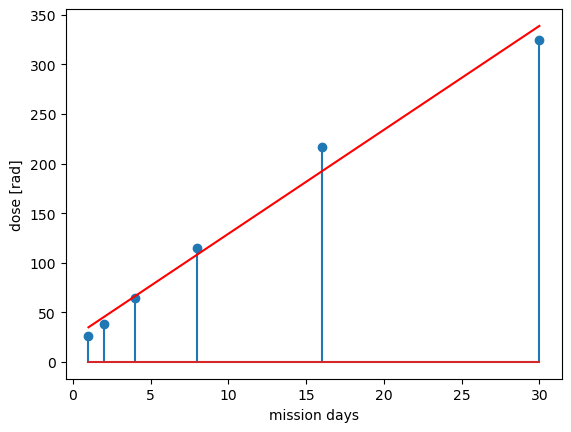

In [5]:
mission_days=np.array([1,2,4,8,16,30])
mission_dose_days_rad=np.array([2.626E+01,3.850E+01,6.402E+01,1.153E+02,2.172E+02,3.247E+02])
dose_0_rad,dose_per_day_in_rad=np.linalg.lstsq(np.array([np.ones_like(mission_days), mission_days]).T, mission_dose_days_rad, rcond='warn')[0]
interp=dose_0_rad+dose_per_day_in_rad * mission_days
plt.figure(0)
plt.stem(mission_days, mission_dose_days_rad)
plt.plot(mission_days, interp, color="red")
plt.xlabel("mission days")
plt.ylabel("dose [rad]")

To model TID in PASEOS, we can use custom properties. First of all, we define a property called `total_ionizing_dose`. We, then, create a dedicated update function `prop_update_fn` to compute the TID over time.

In [6]:
# Add a custom property which tracks the TID
prop_name = "total_ionizing_dose"
# Define the update function
def prop_update_fn(actor, dt, power_consumption):
    return actor.get_custom_property(prop_name) + dose_per_day_in_rad/(24 * 3600) * dt

We can now add a custom property that models the `total_ionizing_dose`, which is updated as described by `prop_update_fn`.

In [7]:
ActorBuilder.add_custom_property(actor=sat, property_name=prop_name, update_function=prop_update_fn, initial_value=dose_0_rad)

# 4) - Calculate the probability of a failure due to the TID

According to the works [Wang, Jian-zhao et al.](https://www.sciencedirect.com/science/article/pii/S0026271422002712?casa_token=PbtCHwrwtKwAAAAA:hddUtlxhJM_CC-nUZBuxG2qZ7793olmDjTO7ZyztDxjjsteCl1fxvlh88SjEiRIeGVR430Po4EJW), [Xapsos, M. A., et al.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7563310), the failure probability due to TID ($P_{failure}$) can be calculates as follows: 

<br> $P_{failure}=\int_{0}^{dose(t)} (1-H(x)) \cdot g(x) \cdot dx $

where:

- $g(x)$ is the Probability Density Function of the devices' failure doses.
- $H(x)$ is the cumulative distribution function of radiation dose from space during the mission period. 

To estimate $H(dose)$, we centered a lognormal distribution $h(dose)$ in the value of the dose [Wang, Jian-zhao et al.](https://www.sciencedirect.com/science/article/pii/S0026271422002712?casa_token=PbtCHwrwtKwAAAAA:hddUtlxhJM_CC-nUZBuxG2qZ7793olmDjTO7ZyztDxjjsteCl1fxvlh88SjEiRIeGVR430Po4EJW). Then,  we calculated the cumulative distributed function $H(dose)$. <br> To estimate the variability of the curve as defined in [Wang, Jian-zhao et al.](https://www.sciencedirect.com/science/article/pii/S0026271422002712?casa_token=PbtCHwrwtKwAAAAA:hddUtlxhJM_CC-nUZBuxG2qZ7793olmDjTO7ZyztDxjjsteCl1fxvlh88SjEiRIeGVR430Po4EJW), we used as sample the values reported in the sun-synchronous orbit for 100 mils reported in [Xapsos, M. A., et al.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7563310).

In [8]:
def get_lognormal_pdf(mean, std, domain):
    #Calculate h(dose)
    return (np.exp(-(np.log(domain) - mean)**2 / (2 *  std**2))
       / (domain *  std * np.sqrt(2 * np.pi)))

In [9]:
#Dose values
dose_span=np.linspace(1e-15, 1009*dose_30_days_rad, 20000)

# h power density function
pdf_h=get_lognormal_pdf(np.log(dose_30_days_rad/2), np.log(dose_30_days_rad/100), dose_span)

# Calculate the H cumulative distribution function
cdf_h=np.zeros_like(dose_span)
for n in range(len(dose_span)):
    cdf_h[n]=np.trapz(pdf_h[:n], dose_span[:n])

$g(dose)$ shall be specified by the user depending on the target component.  We used a lognormal Probability Density Function centered on the average TID value. <br> For this example, we use an unreasonably low TID value (i.e., 200 rad) to possibly experience a failure during the mission in a short time.

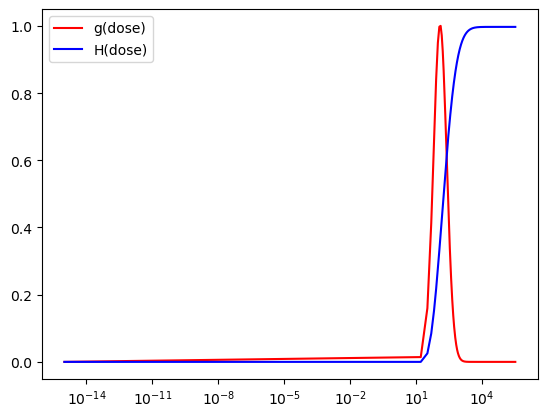

In [10]:
TID_rad = 200
pdf_g=get_lognormal_pdf(np.log(TID_rad), np.log(TID_rad/100), dose_span)


plt.figure(2)
plt.semilogx(dose_span, pdf_g/pdf_g.max(), color="red", label="g(dose)")
plt.semilogx(dose_span, cdf_h, color="blue", label="H(dose)")
plt.legend()
plt.show()

H=dict(zip(dose_span, cdf_h))
g= dict(zip(dose_span, pdf_g))

We can now generate a constraint function that checks if a failure event happens.

In [11]:

def constraint_func_TID_failure():
    dose=sat.get_custom_property("total_ionizing_dose")
    print("Time:", sat.local_time, "Dose [rad]: ", dose)

    
    #Finding the closest domain value to the dose
    dose_nearest_idx = (np.abs(dose_span - dose)).argmin()
    
    #Calculating the probability 
    y=np.zeros_like(dose_span)
    
    for n in range(dose_nearest_idx):
        y[n]=(1 - H[dose_span[n]]) * g[dose_span[n]]
        
    p=np.trapz(y, dose_span)
    
    
    
    
    #Sampling uniform distribution probability 
    p_s = np.random.randint(1, 100000)
    
    
    if (p_s < int(round(p*100000))):
        print("------------------------------------------------")
        print("Detected fault due to TID!")
        print("Damage probability: ", p)
        print("Time:", sat.local_time)
        return False
    else:
        return True


# 5) - Let's test it out

Let's advance the time of 30 days and check if an interrupt happens.

In [12]:
sim.advance_time(3600 * 24 * 30, 10, constraint_function=constraint_func_TID_failure)

18:39:13|PASEOS-WARNING| Property total_ionizing_dose was not tracked beforem, adding now.


Time: 2022-Oct-27 12:00:00 Dose [rad]:  24.436735570469867
Time: 2022-Oct-27 12:00:00 Dose [rad]:  24.436735570469867
Time: 2022-Oct-28 00:00:10 Dose [rad]:  29.678601033425686
Time: 2022-Oct-28 12:00:19 Dose [rad]:  34.920466496390056
Time: 2022-Oct-29 00:00:29 Dose [rad]:  40.162331959361225
Time: 2022-Oct-29 12:00:39 Dose [rad]:  45.404197422332395
Time: 2022-Oct-30 00:00:49 Dose [rad]:  50.646062885303564
Time: 2022-Oct-30 12:00:59 Dose [rad]:  55.887928348274734
Time: 2022-Oct-31 00:01:10 Dose [rad]:  61.129793811245904
Time: 2022-Oct-31 12:01:20 Dose [rad]:  66.37165927420318
Time: 2022-Nov-01 00:01:29 Dose [rad]:  71.61352473714365
Time: 2022-Nov-01 12:01:39 Dose [rad]:  76.85539020008412
Time: 2022-Nov-02 00:01:49 Dose [rad]:  82.09725566302458
Time: 2022-Nov-02 12:01:59 Dose [rad]:  87.33912112596505
Time: 2022-Nov-03 00:02:09 Dose [rad]:  92.58098658890552
Time: 2022-Nov-03 12:02:20 Dose [rad]:  97.82285205184598
Time: 2022-Nov-04 00:02:30 Dose [rad]:  103.06471751478645
Time

1684590.0